# Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

#### Example 1

In this example we will manually type in a bounding box to display the GSKY layer, or select from a list of hard coded bounding boxes.

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.
- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.
    -- where an area around a single point is calculated ("LoadingCloudfreeSentinel2andLandsat.ipynb").
- Identifying an area which has data is a challenge. 
    - Hence, a number of BBoxes, which are known to have data are hard coded. 
    - Selecting a date will auto select the correct BBox.
- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.
- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.
    - Only 2 time slices have valid BBoxes hard coded. 
    - The fourth time uses the whole of Australia.
- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.
- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 21 October, 2019

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox). Instead of manually typing in the BBox, you can select a time to use hard coded BBoxes.

- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment a code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use (from 0 to n_times-1).

- If you know another BBox with data (Tip: use TerriaMap to find) then type it in as,
    - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [1]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 18/10/2019  #
##########################################################

from owslib.wcs import WebCoverageService
from random import randrange
import os
import xarray as xr
%matplotlib inline

### GSKY server and layer name

The GSKY Capability Endpoint URL is specified in the cell below. A layer must also be hard coded. You can display all layers in the dataset and choose any layer.

In [2]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
wcs = WebCoverageService(gsky_url, version='1.0.0')
layer = "landsat8_nbar_16day"

# Uncomment below to see all layers.

#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

### Time position

To get the data it is necessary to send a single time position. You can uncomment a line to display all vailable time positions.

In [3]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
# This time slice is specified below. 
t = n_times-1

# Uncomment the line below to see all time positions.
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])


### Construct a boundong box

To get the data from GSKY it is necessary to send the request with a layer, time and bounding box. In the cell below the bounding box can be manually typed in or selected based on the time position. To match the plot area it is required to adjuct the bounding box, which is done by increasing or decreasing the longitude span. This adjustment may mean that more or less area will be retrieved than asked for. Without this adjutment the image may look stretched or compressed. 

In [4]:
# Specify a 2D array of BBoxes as west, north, east, south in EPSG:4326
w = 10;
BBoxes = [0 for x in range(w)] 
BBoxes[0] = ['140.00,-27.01,141.00,-29.00']
BBoxes[1] = ['130.00,-27.00,131.00,-29.00']
BBoxes[2] = ['150.00,-27.00,151.00,-29.00']
BBoxes[3] = ['112.47,-11.14,154.02,-43.59'] # Australia
t = 2
# A valid BBox with data will be automatically chosen for that date.
bbox = BBoxes[t]

# If you know another BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['130.00,-27.00,131.00,-29.00']

x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 337)))
bbox = (x,y,X,Y)
bbox

(150.0, -27.0, 153.06, -29.0)

### Construct the GSKY end point URL

The GSKY capability endpoint URL is constructed below. You must specify a style ('fc' or 'tc').

In [5]:
# Construct a WCS call to GSKY and send it.
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=150.0%2C-27.0%2C153.06%2C-29.0&time=2013-04-20T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=fc


### Write the data into a temporary file

The GSKY server returns the data in NetCDF format, which is now written to a file.

In [6]:
# Get the output data from GSKY and write it in a *.nc file
rand = str(randrange(1000))
ncfile = './output/gsky_wcs_' + rand + '.nc'
with open(ncfile, 'wb') as f:
    f.write(output.read())

### Read and convert the data

To use in plotting it is necessary to convert the NetCDF data into an Xarray dataset.

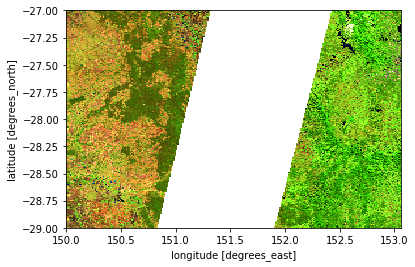

In [7]:
# Read the NetCDF file and convert it into an xarray dataset
landsat_ds = xr.open_dataset(ncfile)

# Delete the created NetCDF file
try:
    os.remove(ncfile)
except OSError:
    pass

# Plot the three bands in the dataset.
landsat_ds[['Band1', 'Band2', 'Band3']].to_array().plot.imshow(robust=True)


***
#### Acknowledgements

This notebook page is derived from this [DEA notebook](https://docs.dea.ga.gov.au/notebooks/05_Temporal_analysis/LoadingCloudfreeSentinel2andLandsat.html) and extensively changed to use GSKY server. Some of the text used here are directly copied from the DEA page.